In [348]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy.stats import multivariate_normal
import pandas as pd
import sklearn


import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Layer, Dropout, BatchNormalization, LeakyReLU, Lambda
from keras.losses import Loss, binary_crossentropy, mean_squared_error, MeanSquaredError
from keras.optimizers import Optimizer, Adam, RMSprop
from keras.metrics import Mean, RootMeanSquaredError
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical, plot_model, load_img, img_to_array
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import load_model

import tensorflow_probability as tfp

The DenseVariational layer calls the call method of the PriorLayer and the custom posterior layer, passing the dummy tensor as input.
In the PriorLayer, the call method calls the self.prior layer with the dummy tensor. Since the lambda function ignores the input tensor and always returns a MultivariateNormalDiag distribution with fixed parameters, the input tensor has no effect on the output.

In [546]:
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
class PriorLayer(Layer):
    def __init__(self, kernel_size, bias_size, dtype=None):
        super().__init__()

        self.kernel_size = kernel_size
        self.bias_size = bias_size
        n = self.kernel_size + self.bias_size

        # Create a prior distribution with MultivariateNormalDiag
        # MultivariateNormalDiag represents a diagonal multivariate normal distribution,
        # which assumes no correlation between the dimensions.
        prior = tfp.distributions.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n))
        
        # Wrapper: Convert distribution object to be used in a Keras model.
        # DistributionLambda is used to wrap a custom TensorFlow Probability distribution
        # into a Keras layer.
        self.wrapper_prior = tfp.layers.DistributionLambda(lambda _: prior)

    def call(self, _):
        # In the call method, we pass the dummy_input to the wrapper_prior.
        # The output will be the prior distribution.
        x = self.wrapper_prior(_)
        return x


it's common to use a prior with fixed parameters, such as a standard normal distribution, and a posterior distribution with learnable parameters in a Bayesian regression model. This is because we generally want to encode some prior knowledge or assumptions about the distribution of the parameters into the model, but also allow the data to inform and update those beliefs.

In the wine quality dataset, if you don't have any specific prior knowledge or assumptions about the distribution of the parameters, you could use a standard normal distribution as your prior, and learn the parameters of a multivariate normal distribution as your posterior.

In [545]:
class PosteriorLayer(Layer):
    def __init__(self, kernel_size, bias_size, dtype=None):
        super(PosteriorLayer, self).__init__()
        self.kernel_size = kernel_size
        self.bias_size = bias_size
        n = self.kernel_size + self.bias_size

        # Instantiate the VariableLayer with the necessary number of parameters
        # for the MultivariateNormalTriL distribution.
        self.variable_layer = tfp.layers.VariableLayer(
            tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
        )

        # Create an instance of the MultivariateNormalTriL layer with the required
        # total number of parameters (kernel_size + bias_size).
        self.multivariate_normal_tril = tfp.layers.MultivariateNormalTriL(n)

    def call(self, inputs):
        # Generate the parameters for the MultivariateNormalTriL distribution
        # using the VariableLayer. The inputs are just a dummy variable to
        # activate the call method of the VariableLayer.
        params = self.variable_layer(inputs)

        # Create a new instance of the MultivariateNormalTriL distribution with
        # the generated parameters and return it.
        return self.multivariate_normal_tril(params)


In [547]:
class BNN(Model):
    def __init__(self,
                 layer_units: list = [8, 8],
                 output_unit: int = 1,
                 activation_func: str = "sigmoid",
                 kl_weight: float = 1e-3,
                 name = "BNN"):
        super().__init__(name = name)

        self.layer_units = layer_units
        self.output_unit = output_unit
        self.activation_func = activation_func
        self.kl_weight = kl_weight

        self.batch_normalization  = BatchNormalization(name = "BatchNormalization")
        self.dense_var_layer = []
        for count, units in enumerate(layer_units):
            self.dense_var_layer.append( tfp.layers.DenseVariational(units = units,
                                            make_posterior_fn = self.make_posterior_fn,
                                            make_prior_fn = self.make_prior_fn ,
                                            kl_weight = kl_weight,
                                            activation = activation_func,
                                            name='DenseVariational_{}'.format(count))
            )
        
        self.output_layer = Dense(units = self.output_unit ,name='DenseOutput')
    
    def make_posterior_fn(self, kernel_size, bias_size, dtype=None):
        return PosteriorLayer(kernel_size, bias_size, dtype)
   
    def make_prior_fn(self, kernel_size, bias_size, dtype=None):
        return PriorLayer(kernel_size, bias_size, dtype)
    
    def call(self, x):
        x = self.batch_normalization(x)
        for dense_var_layer in self.dense_var_layer:
            x = dense_var_layer(x)
        x = self.output_layer(x)    
        return x

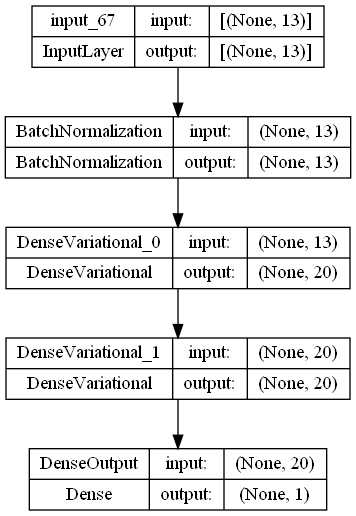

In [344]:
input = Input(shape = (13,))
bnn = BNN()

model = Model(inputs =input, outputs = bnn.call(input))
plot_model(model, show_shapes=True, show_layer_names=True)

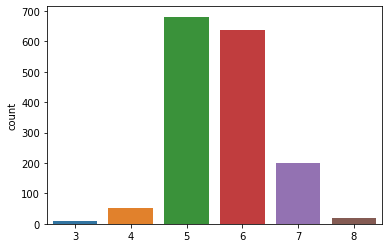

In [511]:
data = pd.read_csv('Data/winequality-red.csv')
X = data.drop(['quality'], axis = 1).to_numpy()
Y = data['quality'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle = True)

# Normalize to have a mean of 0 and a standard deviation of 1
x_mean = np.mean(X_train, axis=0)
x_std = np.std(X_train, axis=0)

x_train_normalized = (X_train - x_mean) / x_std
x_test_normalized = (X_test - x_mean) / x_std

sns.countplot(x = Y)
plt.show()

In [548]:
train_size = int(x_train_normalized.shape[0]*0.85)
bnn = BNN(kl_weight = 1/train_size)

bnn.compile(optimizer = RMSprop(learning_rate = 0.001),
            loss = MeanSquaredError(),
            metrics = [MeanSquaredError()])

history = bnn.fit(x_train_normalized, y_train, epochs = 250, batch_size = 32, validation_data = (x_test_normalized, y_test ))

Epoch 1/250
38/38 [==============================] - 6s 33ms/step - loss: 33.0395 - mean_squared_error: 32.9936 - val_loss: 31.7886 - val_mean_squared_error: 32.1458
Epoch 2/250
38/38 [==============================] - 0s 3ms/step - loss: 29.7969 - mean_squared_error: 29.7688 - val_loss: 29.9147 - val_mean_squared_error: 29.8830
Epoch 3/250
38/38 [==============================] - 0s 2ms/step - loss: 27.4742 - mean_squared_error: 27.4919 - val_loss: 26.5259 - val_mean_squared_error: 26.6100
Epoch 4/250
38/38 [==============================] - 0s 3ms/step - loss: 24.6723 - mean_squared_error: 24.6630 - val_loss: 23.5457 - val_mean_squared_error: 23.7114
Epoch 5/250
38/38 [==============================] - 0s 4ms/step - loss: 22.5195 - mean_squared_error: 22.4287 - val_loss: 21.9067 - val_mean_squared_error: 21.8205
Epoch 6/250
38/38 [==============================] - 0s 2ms/step - loss: 20.6725 - mean_squared_error: 20.6082 - val_loss: 19.8287 - val_mean_squared_error: 19.9212
Epoch 7/2

In [549]:
train_preds = bnn.predict(x_train_normalized).squeeze()
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
print(f"Train RMSE: {round(train_rmse, 3)}")

test_preds = bnn.predict(x_test_normalized).squeeze()
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
print(f"Test RMSE: {round(test_rmse, 3)}")

38/38 [==============================] - 1s 757us/step
Train RMSE: 0.675000011920929
13/13 [==============================] - 0s 667us/step
Test RMSE: 0.6850000023841858


In [550]:
rounded_predictions = np.round(bnn.predict(x_test_normalized))

# If you want to flatten the array
rounded_predictions_flat = rounded_predictions.flatten()
for idx in range(len(y_test)):
    print(f"Predicted: {int(rounded_predictions[idx][0])} - Actual: {y_test[idx]}")

13/13 [==============================] - 0s 1ms/step
Predicted: 5 - Actual: 5
Predicted: 6 - Actual: 6
Predicted: 6 - Actual: 6
Predicted: 5 - Actual: 5
Predicted: 5 - Actual: 5
Predicted: 6 - Actual: 6
Predicted: 6 - Actual: 6
Predicted: 6 - Actual: 5
Predicted: 6 - Actual: 6
Predicted: 5 - Actual: 6
Predicted: 6 - Actual: 8
Predicted: 6 - Actual: 6
Predicted: 5 - Actual: 6
Predicted: 6 - Actual: 6
Predicted: 6 - Actual: 5
Predicted: 6 - Actual: 7
Predicted: 5 - Actual: 6
Predicted: 5 - Actual: 6
Predicted: 6 - Actual: 7
Predicted: 6 - Actual: 6
Predicted: 5 - Actual: 4
Predicted: 6 - Actual: 5
Predicted: 5 - Actual: 5
Predicted: 6 - Actual: 5
Predicted: 5 - Actual: 6
Predicted: 5 - Actual: 5
Predicted: 5 - Actual: 6
Predicted: 6 - Actual: 6
Predicted: 6 - Actual: 5
Predicted: 6 - Actual: 5
Predicted: 5 - Actual: 6
Predicted: 6 - Actual: 7
Predicted: 5 - Actual: 5
Predicted: 5 - Actual: 5
Predicted: 6 - Actual: 6
Predicted: 5 - Actual: 5
Predicted: 5 - Actual: 5
Predicted: 5 - Actual:

13/13 [==============================] - 0s 1ms/step


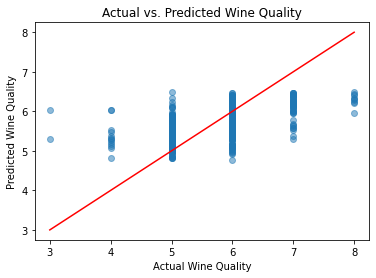

In [551]:
# Predict the wine quality scores for the test set
y_pred = bnn.predict(x_test_normalized)

# Create a scatter plot of the actual vs. predicted wine quality scores
plt.scatter(y_test,  y_pred, alpha=0.5)
plt.xlabel('Actual Wine Quality')
plt.ylabel('Predicted Wine Quality')

# Add a diagonal line to represent the perfect prediction line
min_value = min(min(y_test), min(y_pred))
max_value = max(max(y_test), max(y_pred))
plt.plot([min_value, max_value], [min_value, max_value], 'r')

# Add a title and show the plot
plt.title('Actual vs. Predicted Wine Quality')
plt.show()

In [554]:
mae = sklearn.metrics.mean_absolute_error(y_test, bnn.predict(x_test_normalized))
print(f"Mean Absolute Error: {mae}")

13/13 [==============================] - 0s 667us/step
Mean Absolute Error: 0.5063817775249482


13/13 [==============================] - 0s 1ms/step


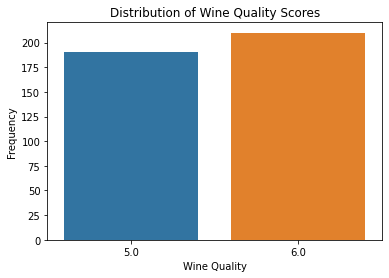

In [583]:
rounded_predictions = np.round(bnn.predict(x_test_normalized))
sns.countplot(x= rounded_predictions.flatten())
plt.xlabel('Wine Quality')
plt.ylabel('Frequency')
plt.title('Distribution of Wine Quality Scores')
plt.show()

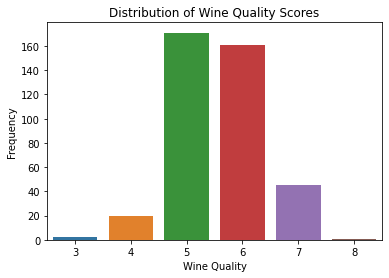

In [443]:
sns.countplot(x=y_test)
plt.xlabel('Wine Quality')
plt.ylabel('Frequency')
plt.title('Distribution of Wine Quality Scores')
plt.show()